In [ ]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from imblearn.over_sampling import RandomOverSampler
from scipy.cluster.vq import kmeans,vq
from scipy.cluster.hierarchy import fcluster,linkage
from scipy.stats.mstats import winsorize
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [ ]:
!wget https://raw.githubusercontent.com/gaz-b5/CL653_Project/main/Train.csv

--2024-04-25 19:27:05--  https://raw.githubusercontent.com/gaz-b5/CL653_Project/main/Train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5526884 (5.3M) [text/plain]
Saving to: ‘Train.csv.1’

Train.csv.1         100%[===================>]   5.27M  --.-KB/s    in 0.05s   

2024-04-25 19:27:06 (100 MB/s) - ‘Train.csv.1’ saved [5526884/5526884]



In [ ]:
df=pd.read_csv('/content/Train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763 entries, 0 to 1762
Columns: 1559 entries, feature_1 to Class
dtypes: float64(1), int64(1558)
memory usage: 21.0 MB


# Shortlisting and Quality checking problems generally have imbalanced data points so checking for same

In [ ]:
df.Class.value_counts()

Class
0    1620
1     143
Name: count, dtype: int64

imbalanced, so need to oversample

## Checking for outliers

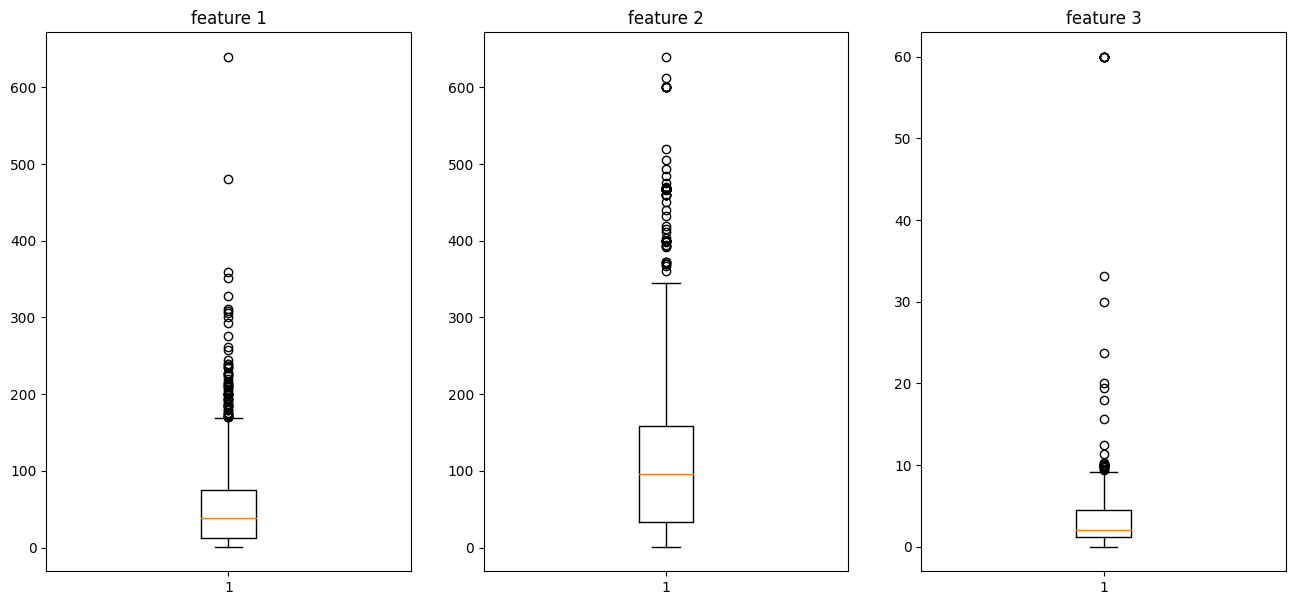

In [ ]:

fig, axs =  plt.subplots(1,3,figsize = (16,7))
for i in range(3):
    axs[i].set_title(f'feature {i+1}')
    axs[i].boxplot(df[f'feature_{i+1}'])

## Outlier Removal

In [ ]:
for col in df.columns[:3]:
    l=0.1 if col=='feature_2' else 0.05
    df[col]=winsorize(df[col],limits=l)
df

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558,Class
0,100,160,1.6000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20,83,4.1500,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,99,150,1.5151,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,40,40,1.0000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12,234,8.4166,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1758,1,1,2.0000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1759,40,200,5.0000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1760,96,218,2.2708,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1761,16,81,5.0625,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


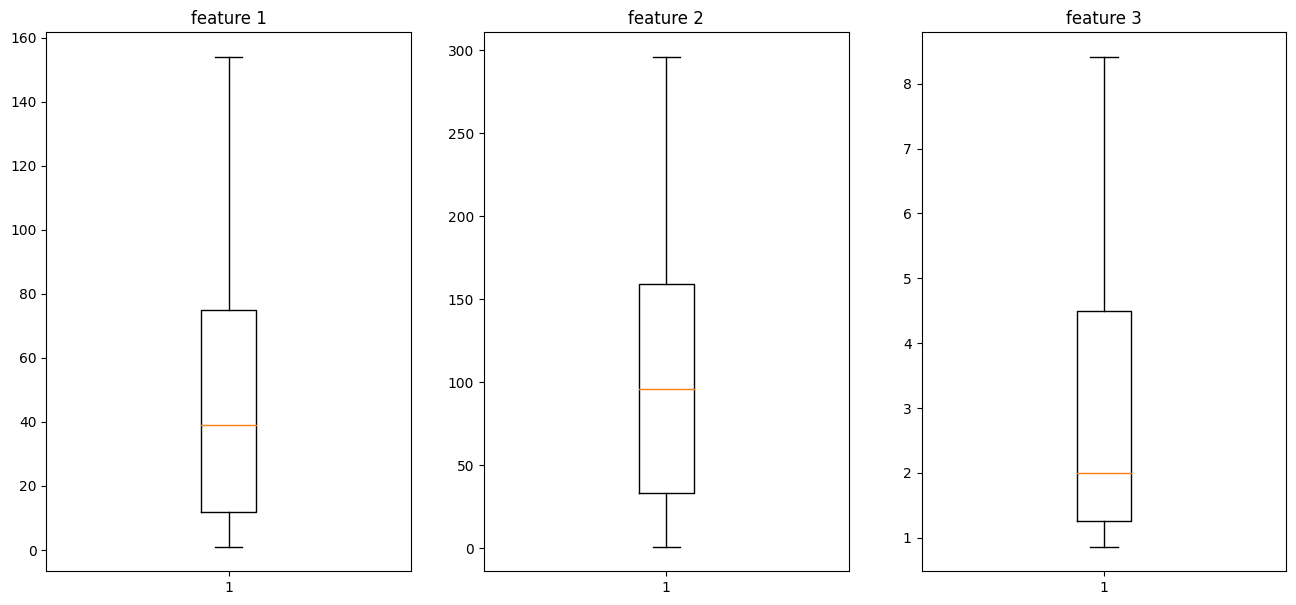

In [ ]:
fig, axs =  plt.subplots(1,3,figsize = (16,7))
for i in range(3):
    axs[i].set_title(f'feature {i+1}')
    axs[i].boxplot(df[f'feature_{i+1}'])

## Standard Scaling

In [ ]:
df2=pd.DataFrame(StandardScaler().fit_transform(df.iloc[:,:3]),columns=df.columns[:3])
df=pd.concat([df2,df.iloc[:,3:]],axis=1)
df

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558,Class
0,1.078244,0.536706,-0.617120,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.657223,-0.302744,0.401092,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,1.056550,0.427686,-0.651021,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.223356,-0.771527,-0.856700,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.830770,1.343449,2.104740,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1758,-1.069396,-1.196703,-0.457401,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1759,-0.223356,0.972783,0.740496,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1760,0.991470,1.169018,-0.349271,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1761,-0.743996,-0.324548,0.765452,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
x = df.drop('Class',axis=1)
y = df['Class']

## Oversampling using SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

def over_sample_train_test(x,y):
    ros=SMOTE()
    x_res,y_res=ros.fit_resample(x,y)
    x_train,x_test,y_train,y_test=train_test_split(x_res,y_res,test_size=0.2,random_state = 1)
    return x_train,x_test,y_train,y_test

x_train,x_test,y_train,y_test=over_sample_train_test(x,y)

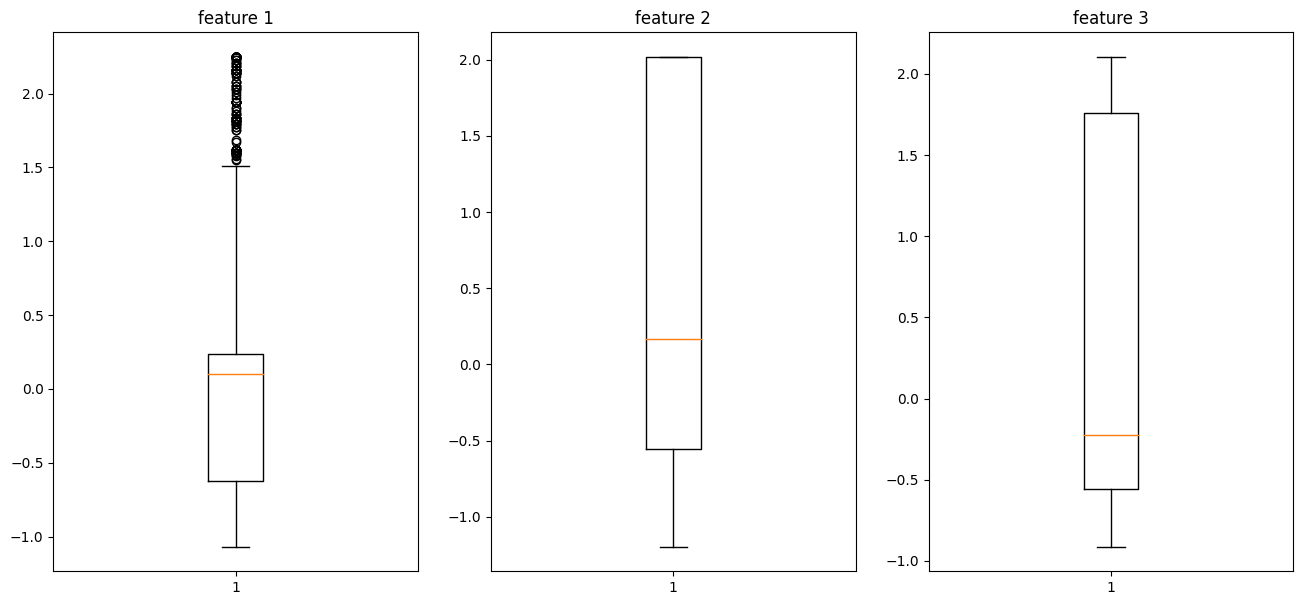

In [ ]:
fig, axs =  plt.subplots(1,3,figsize = (16,7))
for i in range(3):
    axs[i].set_title(f'feature {i+1}')
    axs[i].boxplot(x_train[f'feature_{i+1}'])

In [ ]:
y_train.value_counts()

Class
1    1300
0    1292
Name: count, dtype: int64

In [ ]:

import pandas as pd
pca = PCA(n_components=20)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

x_train_pca = pd.DataFrame(x_train_pca)
x_test_pca = pd.DataFrame(x_test_pca)


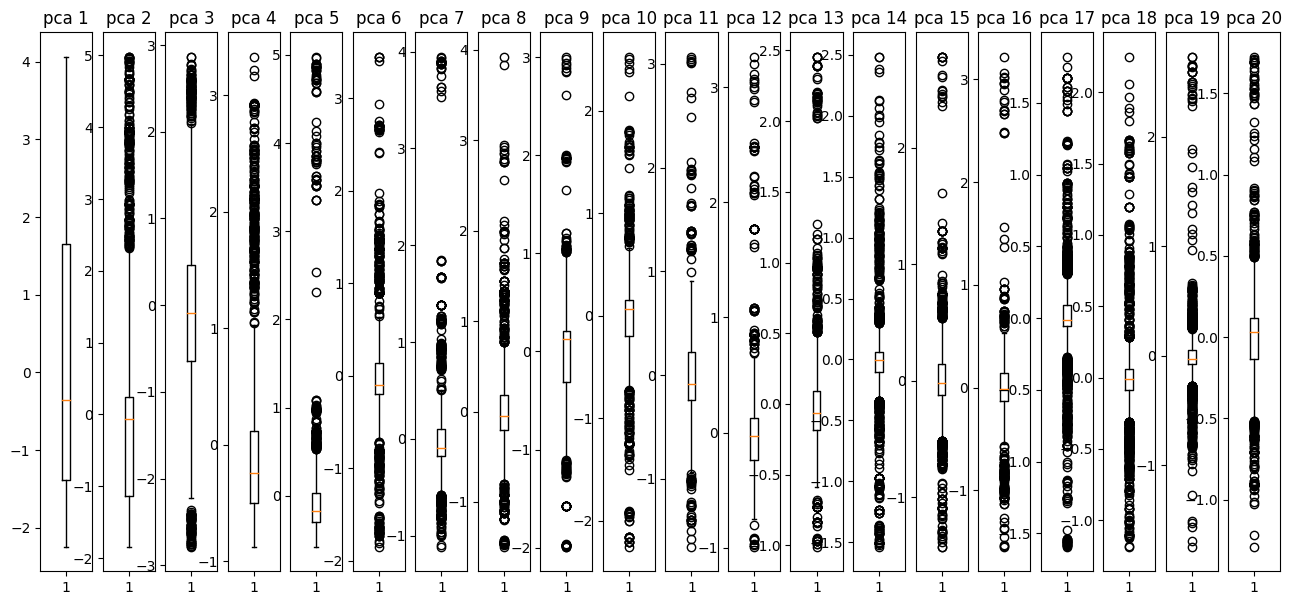

In [ ]:
fig, axs =  plt.subplots(1,20,figsize = (16,7))
for i in range(20):
    axs[i].set_title(f'pca {i+1}')
    axs[i].boxplot(x_train_pca[i])

In [ ]:
x_train_pca.shape

(2592, 20)

In [ ]:
lr=LogisticRegression(solver='liblinear')
svm=SVC(probability=True)
dt=DecisionTreeClassifier(max_depth=10,max_features=8,random_state=100)
rf=RandomForestClassifier(max_depth=4, max_features=3)
knn=KNeighborsClassifier(n_neighbors=94)
gnb=GaussianNB()
xgb=xgb=XGBClassifier(use_label_encoder=False,random_state=42,eval_metric='mlogloss')

models = [lr,svm,dt,rf,knn,gnb,xgb];

In [ ]:
def apply_model(model,x_train,x_test,y_train,y_test):
    print(' '*20+re.search(r'(.*)\(',f'''{model}''',re.M).group(1))
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    print('')
    print('Train Score:  ',model.score(x_train,y_train))
    print('Test Score:   ',model.score(x_test,y_test))
    print('')
    # print(classification_report(y_test,y_pred))


## **Without Dimensionality Reduction**

In [ ]:
test_scores = []
for model in models:
  apply_model(model,x_train,x_test,y_train,y_test)
  model.fit(x_train, y_train)
  test_scores.append(model.score(x_test, y_test))

                    LogisticRegression

Train Score:   0.9274691358024691
Test Score:    0.9104938271604939

                    SVC

Train Score:   0.9402006172839507
Test Score:    0.9089506172839507

                    DecisionTreeClassifier

Train Score:   0.6643518518518519
Test Score:    0.6682098765432098

                    RandomForestClassifier

Train Score:   0.8294753086419753
Test Score:    0.8194444444444444

                    KNeighborsClassifier

Train Score:   0.6292438271604939
Test Score:    0.6203703703703703

                    GaussianNB

Train Score:   0.8969907407407407
Test Score:    0.8842592592592593

                    XGBClassifier

Train Score:   0.9645061728395061
Test Score:    0.9182098765432098



In [ ]:
# prompt: make a dataframe with names of models used in one column and test score pf that moulmn in the next column

import pandas as pd
results = pd.DataFrame({
    "Model": ["Logistic Regression", "SVM", "Decision Tree", "Random Forest", "KNN", "Naive Bayes", "XGBoost"],
    "Test Score": test_scores
})
results.set_index("Model", inplace=True)

print(results)


                     Test Score
Model                          
Logistic Regression    0.910494
SVM                    0.908951
Decision Tree          0.668210
Random Forest          0.685185
KNN                    0.620370
Naive Bayes            0.884259
XGBoost                0.918210


## **PCA**

In [ ]:
test_scores_pca = []
for model in models:
  apply_model(model,x_train_pca,x_test_pca,y_train,y_test)
  model.fit(x_train_pca, y_train)
  test_scores_pca.append(model.score(x_test_pca, y_test))

                    LogisticRegression

Train Score:   0.8101851851851852
Test Score:    0.7947530864197531

                    SVC

Train Score:   0.841820987654321
Test Score:    0.8194444444444444

                    DecisionTreeClassifier

Train Score:   0.9521604938271605
Test Score:    0.875

                    RandomForestClassifier

Train Score:   0.8557098765432098
Test Score:    0.8348765432098766

                    KNeighborsClassifier

Train Score:   0.8283179012345679
Test Score:    0.8302469135802469

                    GaussianNB

Train Score:   0.8074845679012346
Test Score:    0.7978395061728395

                    XGBClassifier

Train Score:   0.9942129629629629
Test Score:    0.9182098765432098



In [ ]:
import pandas as pd
results_pca = pd.DataFrame({
    "Model": ["Logistic Regression", "SVM", "Decision Tree", "Random Forest", "KNN", "Naive Bayes", "XGBoost"],
    "Test Score": test_scores_pca
})
results_pca.set_index("Model", inplace=True)

print(results_pca)


                     Test Score
Model                          
Logistic Regression    0.794753
SVM                    0.819444
Decision Tree          0.875000
Random Forest          0.817901
KNN                    0.830247
Naive Bayes            0.797840
XGBoost                0.918210


## **SVD**


In [ ]:

import pandas as pd
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=20)
svd.fit(x_train)

x_train_svd = svd.transform(x_train)
x_test_svd = svd.transform(x_test)

x_train_svd = pd.DataFrame(x_train_svd)
x_test_svd = pd.DataFrame(x_test_svd)



In [ ]:
test_scores_svd = []
for model in models:
  apply_model(model,x_train_svd,x_test_svd,y_train,y_test)
  model.fit(x_train_svd, y_train)
  test_scores_svd.append(model.score(x_test_svd, y_test))

                    LogisticRegression

Train Score:   0.8171296296296297
Test Score:    0.8101851851851852

                    SVC

Train Score:   0.8337191358024691
Test Score:    0.8194444444444444

                    DecisionTreeClassifier

Train Score:   0.964891975308642
Test Score:    0.8827160493827161

                    RandomForestClassifier

Train Score:   0.8410493827160493
Test Score:    0.8287037037037037

                    KNeighborsClassifier

Train Score:   0.8290895061728395
Test Score:    0.8302469135802469

                    GaussianNB

Train Score:   0.8036265432098766
Test Score:    0.7962962962962963

                    XGBClassifier

Train Score:   0.9942129629629629
Test Score:    0.9243827160493827



In [ ]:
results_svd = pd.DataFrame({
    "Model": ["Logistic Regression", "SVM", "Decision Tree", "Random Forest", "KNN", "Naive Bayes", "XGBoost"],
    "Test Score": test_scores_svd
})
results_svd.set_index("Model", inplace=True)

print(results_svd)

                     Test Score
Model                          
Logistic Regression    0.810185
SVM                    0.819444
Decision Tree          0.882716
Random Forest          0.841049
KNN                    0.830247
Naive Bayes            0.796296
XGBoost                0.924383


# Hyper parameter tuning:
The best result was obtained from Xgboost model, so applying hyperparameter tuning on the model.

In [ ]:
# prompt: apply hyperparameter tuning on xgboost model and run all datsets, without dimensionality reduction

from sklearn.model_selection import GridSearchCV
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'n_estimators' : [100, 200, 500, 1000],
    'objective': ['binary:logistic'],
    'gamma': [0, 0.25, 0.5, 1.0]
}
grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'), param_grid, refit=True, verbose=3, n_jobs=-1)
grid.fit(x_train, y_train)
print(grid.best_params_)
best_xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', **grid.best_params_)
best_xgb.fit(x_train, y_train)
print('Train Score:', best_xgb.score(x_train, y_train))
print('Test Score:', best_xgb.score(x_test, y_test))

Fitting 5 folds for each of 107520 candidates, totalling 537600 fits
